# Ising Chain with two nearest-neighbors

In [1]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from isingchat import style
from isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.signal import savgol_filter

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Data handling

### Import properties data from disk

In [2]:
config_file = Path("./config/alpha-2_h-0_id-16.yml").resolve()
energy_file = config_file.with_suffix(".free-energy.h5")

In [3]:
with config_file.open() as cfp:
    config_info = yaml.load(cfp)
config_data = read_ising_config(config_info)

with h5py.File(str(energy_file)) as h5fp:
    data_energy = h5fp["/free-energy"][()]

temp = config_data["system"]["temperature"]
mag_field = config_data["system"]["magnetic_field"]
free_erg = data_energy[:, :]

print(mag_field)
print(np.diff(mag_field))

[0.00000000e+00 9.31701660e-09 1.86340332e-08 2.79510498e-08
 3.72680664e-08 4.65850830e-08 5.59020996e-08 6.52191162e-08
 7.45361328e-08]
[9.3170166e-09 9.3170166e-09 9.3170166e-09 9.3170166e-09 9.3170166e-09
 9.3170166e-09 9.3170166e-09 9.3170166e-09]


### Construct free energy splines for interpolation and finding derivatives

In [4]:
# Zero magnetic field spline
free_erg_spl_zmf = interp.UnivariateSpline(temp,
                                           free_erg[:, 0],
                                           s=0, k=4)
free_erg_spl_full = interp.RectBivariateSpline(temp,
                                               mag_field,
                                               free_erg,
                                               s=0, kx=1, ky=1)

temp_fine = np.linspace(temp.min(), temp.max(), 2048)
mag_field_fine = np.linspace(mag_field.min(), mag_field.max(), num=1024)

mag_field_fine = mag_field

def make_spl_fixed_temp(temp_val: float):
    """"""
    free_erg_fine = free_erg_spl_full(temp_val, mag_field_fine)
    spl = interp.UnivariateSpline(mag_field_fine,
                                  free_erg_fine,
                                  s=0, k=1)
    return spl


# def get_magnetization(temp_val: float):
#     """"""
#     spl = free_erg_spl_map[temp_val]
#     mag_spl = spl.derivative(n=1)
#     # Magnetization at zero field.
#     return -mag_spl(x=0)


# def get_susceptibility(temp_val: float):
#     """"""
#     spl = free_erg_spl_map[temp_val]
# #     mag_spl = spl.derivative(n=2)
#     # Magnetization at zero field.
#     return -mag_spl(x=0)

def get_magnetization(temp_val: float):
    """"""
    free_erg_fine = free_erg_spl_full(temp_val, mag_field_fine)[0, :]
    return -np.gradient(free_erg_fine, mag_field_fine, edge_order=2)


def get_susceptibility(temp_val: float):
    """"""
    magnzn_fine = get_magnetization(temp_val)
    # Magnetization at zero field.
    return np.gradient(magnzn_fine, mag_field_fine, edge_order=2)


free_erg_spl_map = {}
for temp_val in temp_fine:
    free_erg_spl_map[temp_val] = make_spl_fixed_temp(temp_val)

### Get physical properties

In [5]:
# Second derivative of the free energy.
free_erg_der_spl_zmf = free_erg_spl_zmf.derivative(n=2)
cv_fine = -temp_fine * free_erg_der_spl_zmf(temp_fine)
cv_max_idx = np.argmax(cv_fine)
temp_cv_max, cv_max = temp_fine[cv_max_idx], cv_fine[cv_max_idx]

# Magnetization
magnzn = np.array(list(map(get_magnetization, temp_fine)))[:, 0]
mzn_max_idx = np.argmax(magnzn)
temp_mzn_max, mzn_max = temp_fine[mzn_max_idx], magnzn[mzn_max_idx]

# Susceptibility
suscep = np.array(list(map(get_susceptibility, temp_fine)))[:, 0]
suscep_max_idx = np.argmax(suscep)
temp_suscep_max, suscep_max = temp_fine[suscep_max_idx], suscep[
    suscep_max_idx]

print(f"C_V max.: {cv_max:.8G}")
print(f"Temp. at C_V max.: {temp_cv_max:.8G}")

print(f"Suscep. max.: {suscep_max:.15G}")
print(f"Temp. at Suscep. max.: {temp_suscep_max:.15G}")
print(f"{suscep_max_idx}")

C_V max.: 0.092512697
Temp. at C_V max.: 0.5
Suscep. max.: 51872859.6711994
Temp. at Suscep. max.: 0.17875915974597
705


## Plots

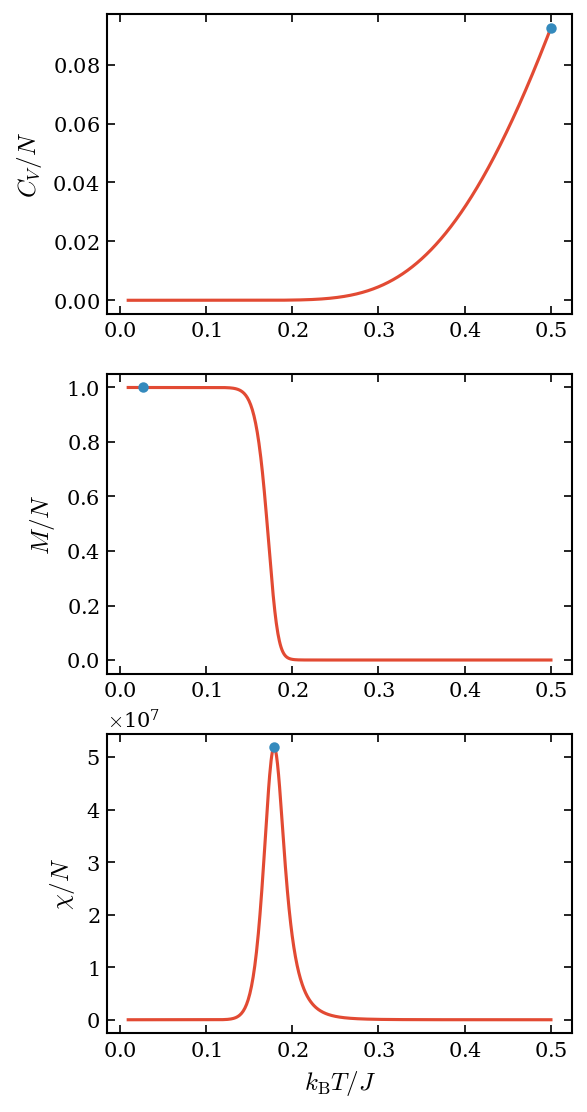

In [6]:
use_tex = False

# Load the default style.
style.use("default")
rcParams["text.usetex"] = use_tex

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(temp_fine, cv_fine, lw=1.5)
ax.plot(temp_cv_max, cv_max, marker="o", lw=0)

# ax.set_xlabel(r"$k_\mathrm{B} T / J$")
ax.set_ylabel(r"$C_V / N$")

# Magnetization subplot.
ax: Axes = fig1.add_subplot(grid_spec[1, 0])

ax.plot(temp_fine, magnzn, lw=1.5)
ax.plot(temp_mzn_max, mzn_max, marker="o", lw=0)

# ax.set_xlim(0, 0.5)

# ax.set_xlabel(r"$k_\mathrm{B} T / J$")
ax.set_ylabel(r"$M / N$")

# Susceptibility subplot.
ax: Axes = fig1.add_subplot(grid_spec[2, 0])

# ax.plot(fabs(temp_fine - temp_suscep_max), suscep, lw=1.5)
ax.plot(temp_fine, suscep, lw=1.5)
ax.plot(temp_suscep_max, suscep_max, marker="o", lw=0)

# ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel(r"$k_\mathrm{B} T / J$")
ax.set_ylabel(r"$\chi / N$")

pyplot.draw()
pyplot.show()

# ax.set_yscale("log")

## Plot the free energy as a function of the magnetic field near the divergence

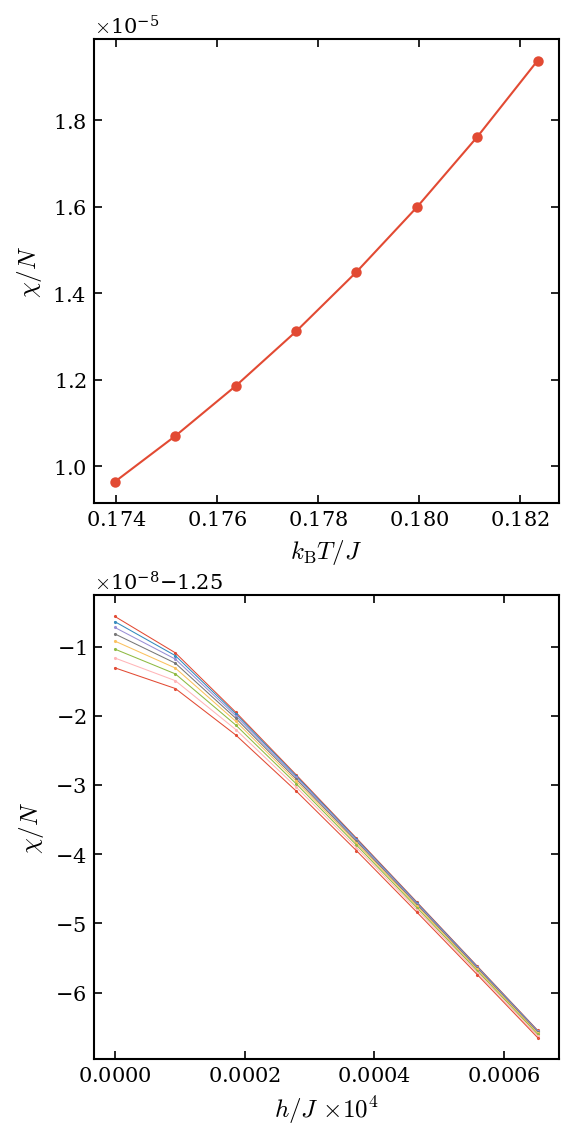

In [7]:
use_tex = False

# Load the default style.
style.use("default")
rcParams["text.usetex"] = use_tex

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(2, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])
    
win_slice = slice(suscep_max_idx-20, suscep_max_idx+20, 5)
# win_slice = slice(0, None)
temp_fine_window = temp_fine[win_slice]
free_erg_windows = -temp_fine_window * free_erg_spl_zmf.derivative(n=2)(temp_fine_window)
suscep_window = suscep[win_slice]

# ax.plot(temp_fine, suscep, lw=1.5)
ax.plot(temp_fine_window, free_erg_windows, marker="o", lw=1)

ax.set_xlabel(r"$k_\mathrm{B} T / J$")
ax.set_ylabel(r"$\chi / N$")

ax: Axes = fig1.add_subplot(grid_spec[1, 0])

for temp_val in temp_fine_window[:]:
    free_erg_spl = free_erg_spl_map[temp_val]
    mag_field_fine_window = mag_field_fine[:8]
    free_erg_window = free_erg_spl(mag_field_fine_window)
#     print(np.gradient(free_erg_spl(mag_field_fine_window), edge_order=2))
#     free_erg_window = -np.gradient(free_erg_spl(mag_field_fine_window), mag_field_fine_window, edge_order=2)
#     free_erg_window = np.gradient(free_erg_window, mag_field_fine_window, edge_order=2)
    ax.plot(mag_field_fine_window * 1e4, free_erg_window, marker="o", lw=0.5, ms=0.5)
    
ax.set_xlabel(r"$h / J$ $ \times 10^{4}$")
ax.set_ylabel(r"$\chi / N$")

pyplot.draw()
pyplot.show()

# ax.set_yscale("log")

In [8]:
step_x = 7.6325e-5 / 256 / 32
step_x, step_x * 8

(9.3170166015625e-09, 7.45361328125e-08)

In [25]:
np.diff(np.linspace(0, step_x * 8, 9))

array([2.98144531e-07, 2.98144531e-07, 2.98144531e-07, 2.98144531e-07,
       2.98144531e-07, 2.98144531e-07, 2.98144531e-07, 2.98144531e-07])

(1e-08, 7e-07)

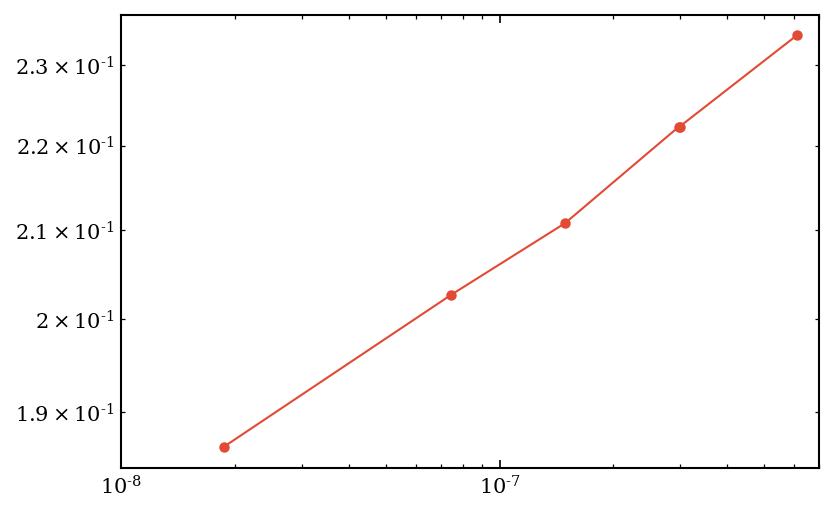

In [48]:
dh_table = array([1.86340332e-08, 7.45361328e-08, 1.49072266e-07, 2.98144531e-07, 2.99313725e-07, 6.12745098e-07])
suscep_table = array([25948631.9688434, 6486836.50431928, 3227763.524, 1620596.04164971, 1614287.98279578, 789016.481420025])
temp_table = array([0.186419149975574, 0.202696629213483, 0.2108353688, 0.222325354176844,  0.222325354176844, 0.233815339521251])

# plot(dh_table, suscep_table, marker="o", lw=1)
plot(dh_table, temp_table, marker="o", lw=1)
#

xscale("log")
yscale("log")

xlim(1e-8, 7e-7)